In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain bs4
! pip install langchain-anthropic langchain_voyageai
! pip install -U langchain-google-genai
! pip install langchain-huggingface ipywidgets

  Using cached tokenizers-0.20.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
Using cached tokenizers-0.20.3-cp311-cp311-macosx_11_0_arm64.whl (2.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.47.1 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.20.3 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
  Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_

In [73]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [53]:
import os
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_anthropic import ChatAnthropic
from langchain_voyageai import VoyageAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

from huggingface_hub import login
login() # You will be prompted for your HF key, which will then be saved locally

# Indexing
Load Documents -> Split -> Add chunks to Vector Store

In [4]:
vectorstore = Chroma(embedding_function=VoyageAIEmbeddings(batch_size=32, model='voyage-3'), persist_directory='./chroma')

/var/folders/qp/cx88xq3j1mq96hp2m3nc3lf00000gn/T/ipykernel_84955/431877094.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=VoyageAIEmbeddings(batch_size=32, model='voyage-3'), persist_directory='./chroma')


In [93]:
#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [ ]:
from time import sleep

# Embed
for i in range(0, len(splits), 10):
    print('Adding', i, i+10)
    documents = splits[i:i+10]
    vectorstore.add_documents(documents=documents)
    sleep(65)

/var/folders/qp/cx88xq3j1mq96hp2m3nc3lf00000gn/T/ipykernel_31867/668048007.py:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=VoyageAIEmbeddings(batch_size=32, model='voyage-3'), persist_directory='./chroma')


Adding 0 10
Adding 10 20
Adding 20 30
Adding 30 40
Adding 40 50
Adding 50 60
Adding 60 70


# Retrieval and Generation

In [8]:
#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")
retriever = vectorstore.as_retriever()

In [9]:
# LLM
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
# llm = ChatAnthropic(model='claude-3-opus-20240229')
# ChatGoogleGenerativeAI
# 2 RPM (requests per minute)
# 32,000 TPM (tokens per minute)
# 50 RPD (requests per day)
# llm = ChatGoogleGenerativeAI(model="gemini-pro")

llm = ChatHuggingFace(
    verbose=True,
    llm=HuggingFaceEndpoint(
        repo_id="meta-llama/Llama-3.2-1B-Instruct",
        task="text-generation",
        max_new_tokens=256,
        do_sample=False,
        repetition_penalty=1.03,
    ))


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is the process of breaking down a complex task into multiple manageable subtasks. It can be done using Language Models like LLMs (e.g., HuggingGPT), task-specific instructions, or human inputs, and has various stages, including task planning and parsing, depending on the prompt and task complexity.'

# Query Translation - rephrasing queries

## Multi-queries
Not all queries are clear enough. Abstract queries can lead to improper embedding vector, which can cause confusion in searching for the right document.
The purpose of this is to translate one query into multiple queries, each tackle one aspect of the query.

My observations: If the questions is lacking details and context, the output is not relevant enough?

Split into multiple queries -> Do retrieve step for each query -> Union results into one set of distinct documents -> Use these documents as output

In [42]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate three 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Just provide the questions, no need to introduce or explain further.
Example output format:
1. <Question 1>
2. <Question 2>
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | llm 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [27]:
generate_queries.invoke({'question': "What is task decomposition for LLM agents?"})

['1. What are the key challenges in task decomposition for Large Language Models (LLMs) agents?',
 '2. What are the most critical concepts for understanding task decomposition in LLMs, and how do they relate to other related areas of research, such as explainability and fairness?',
 '3. How can task decomposition be seen as a specific instance of a broader field of study that encompasses not only LLMs but also other areas like generalization, transfer learning, and model interpretability?']

In [28]:
from langchain.load import dumps, loads
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
                                      # map each question to retriever
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

7

In [29]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (l

In [30]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [35]:
# Chain

rag_chain = (
    {"context": retrieval_chain, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

question = "What is task decomposition for LLM agents?"
rag_chain.invoke({"question": question})

'Task decomposition for Large Language Model (LLM) agents is achieved by breaking down complex tasks into multiple manageable subgoals and generating multiple thoughts per step, creating a tree structure. This is often done by prompting the LLM with simple prompting like "Steps for XYZ.\\\\n1.", "What are the subgoals for achieving XYZ?", or using task-specific instructions such as writing a story outline. Task decomposition is also combined with other techniques like BFS (breadth-first search) or DFS (depth-first'

## Rag Fusion
- Step 1: Multi-queries. Retrieve docs through each query
- Step 2: Add ranking through fused scores for each document

In [96]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

def format_docs_fused_score(result: list[any]): 
    return "\n\n".join(f"Fused Score: {score}\nContent: {doc.page_content}" for (doc, score) in result)

In [ ]:
# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate three 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Just provide the questions, no need to introduce or explain further.
Example output format:
1. <Question 1>
2. <Question 2>
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | llm 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

retrieval_chain = generate_queries | (lambda x: x[:3]) | retriever.map() | get_unique_union

rag_chain = (
    {"context": retrieval_chain, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


In [ ]:
question = "What is task decomposition for LLM agents?"
rag_chain.invoke({"question": question})

In [97]:
template = """Answer the following question based on this context:
{context}

Question: {question}
"""
minimal_prompt = ChatPromptTemplate.from_template(template)

rag_fusion_retrieval_chain = generate_queries | (lambda x: x[:3]) | retriever.map() | reciprocal_rank_fusion
rag_fusion_chain = (
  {"context": rag_fusion_retrieval_chain, "question": RunnablePassthrough()}
  | prompt
  | llm
  | StrOutputParser() )

In [98]:
# sleep(60)
rag_fusion_chain.invoke("What is task decomposition for LLM agents?")

'Task decomposition in LLM agents involves splitting complex tasks into smaller, manageable steps and executing them one by one.'

## Decomposition
Step 1: Do multi-queries

Step 2:
- Option 1: Ask questions recursively, which one answer gets feed into the next question as background information
  ```
  background_info = ''
  for query in multi-queries:
    template = "
      {query}

      {background_info}

      {context}
    "
    answer = prompt(template) | llm
    background_info += "Question: {query} Answer: {answer}"
  ```

- Option 2: Ask questions independently, with one final step to merge the answer
  ```
  background_info = ''
  for query in multi-queries:
    answer = prompt | llm
    background_info += "Question: {query} Answer: {answer}"

  template = "{question} {background info}"
  final_answer = prompt(template) | llm
  ```
    

## Step back
- Step 1: Use few-shot examples to generate a step-back query which is more general than the original question
- Step 2: Ask the question using the context of step-back query and the original query

In [105]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [106]:
few_shot_prompt

FewShotChatMessagePromptTemplate(examples=[{'input': 'Could the members of The Police perform lawful arrests?', 'output': 'what can the members of The Police do?'}, {'input': 'Jan Sindel’s was born in what country?', 'output': 'what is Jan Sindel’s personal history?'}], input_variables=[], input_types={}, partial_variables={}, example_prompt=ChatPromptTemplate(input_variables=['input', 'output'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), AIMessagePromptTemplate(prompt=PromptTemplate(input_variables=['output'], input_types={}, partial_variables={}, template='{output}'), additional_kwargs={})]))

In [125]:
generate_queries_step_back = (
  prompt
  | llm
  | StrOutputParser()
)
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke(question)

"what's the functionality and components of large language models (LLMs)?"

In [112]:
context_step_back = generate_queries_step_back | retriever
context_step_back.invoke({"question": question})

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [ ]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnableParallel
chain = (
    RunnableParallel(
      question=RunnablePassthrough(),
      normal_context=retriever,
      step_back_context=generate_queries_step_back | retriever
  )
  | response_prompt
  | llm
  | StrOutputParser()
)

In [ ]:
chain.invoke(question)

'Task decomposition is a crucial component in Large Language Model (LLM) agents, enabling them to break down complex tasks into smaller, manageable subtasks. This process is essential for improving the efficiency and quality of future tasks. Task decomposition decouples the task-parsing process from the task-execution process, allowing the agent to focus on one subtask at a time, thereby reducing the risk of errors and increasing the overall quality of the final output.\n\nTask decomposition is typically achieved through a combination of methods,'

## HyDE
- Current approach: embed question, embed documents, find cosine similarity
- Potential problem: questions (sentence) and documents (passage) could be mapped to different space because they are very different text object
  - Density: documents are usually large text chunks which can be embedded into dense vectors, whereas questions are usually sentences
  - Wording: documents tend to be written using a more resourceful lexicon, whereas questions are sometimes ill-phrased by the user
- Solution: ask LLM to write a passage from the question and use the new passage as the key to retrieve documents
- Drawback: what if LLM generates a passage with misleading information and hence, the retrieved documents are irrelevant?

# LangGraph

In [12]:
! pip install langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [28]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]



In [32]:
def chatbot_func(state: State):
    return {"messages": [rag_chain.invoke({"question": state["messages"]})]}


In [70]:
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, base_url=os.environ['OPENAI_BASE_URL'])

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
)

def chatbot_func(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


del graph_builder
graph_builder = StateGraph(State)

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("chatbot", chatbot_func)
graph_builder.add_edge("chatbot", END)


In [71]:
graph = graph_builder.compile()

In [72]:
def stream_graph_updates(user_input: str):
    print(f'User input: {user_input}')
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print('\nEvent:')
        print(event)
        print(event.values())
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
        print('----------------------------------')


stream_graph_updates("What is Task Decomposition?")

User input: What is Task Decomposition?

Event:
{'chatbot': {'messages': [AIMessage(content='Task decomposition is the process of breaking down a complex task or project into smaller, more manageable sub-tasks or components. This allows for easier planning, organization, and execution of the overall task. By breaking a task into smaller parts, individuals or teams can focus on completing each sub-task one at a time, leading to a more efficient and effective completion of the overall task. Task decomposition is a common technique used in project management, software development, and other fields to improve productivity and achieve better results.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 13, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

In [74]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [127]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools) # Modification: tell the LLM which tools it can call

def chatbot_func(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


del graph_builder
del graph
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot_func)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


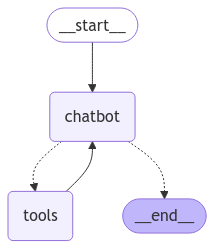

In [115]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [128]:
def stream_graph_updates(user_input: str):
    print(f'User input: {user_input}')
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        print('\nEvent:')
        print(event)
        print(event.values())
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
        print('----------------------------------')


stream_graph_updates("What's a 'node' in LangGraph?")

User input: What's a 'node' in LangGraph?

Event:
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ye6OCLQ0XJ6lPJB39efg7aw3', 'function': {'arguments': '{"query":"What is a \'node\' in LangGraph?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 91, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9b0184f8-7aca-4a27-8c73-ea53af0fff78-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "What is a 'node' in LangGraph?"}, 'id': 'call_Ye6OCLQ0XJ6lPJB39efg7aw3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'o